#### MITA : HATE CRIME CLASSIFICATION

In [352]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [353]:
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

DATA INGESTION

In [354]:
data = pd.read_csv('hate_crime.csv', encoding='Latin1')

/Users/melikaogarro/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


DATA PREPROCESSING / CLEANING

In [355]:
data.head(5)

,INCIDENT_ID,DATA_YEAR,ORI,PUB_AGENCY_NAME,PUB_AGENCY_UNIT,AGENCY_TYPE_NAME,STATE_ABBR,STATE_NAME,DIVISION_NAME,REGION_NAME,...,OFFENDER_RACE,OFFENDER_ETHNICITY,VICTIM_COUNT,OFFENSE_NAME,TOTAL_INDIVIDUAL_VICTIMS,LOCATION_NAME,BIAS_DESC,VICTIM_TYPES,MULTIPLE_OFFENSE,MULTIPLE_BIAS
0,3015,1991,AR0040200,Rogers,NaN,City,AR,Arkansas,West South Central,South,...,White,NaN,1,Intimidation,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-Black or African American,Individual,S,S
1,3016,1991,AR0290100,Hope,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,1,Simple Assault,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,S,S
2,43,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,1,Aggravated Assault,1.0,Residence/Home,Anti-Black or African American,Individual,S,S
3,44,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,2,Aggravated Assault;Destruction/Damage/Vandalis...,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,M,S
4,3017,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,1,Aggravated Assault,1.0,Service/Gas Station,Anti-White,Individual,S,S


In [356]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219577 entries, 0 to 219576
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   INCIDENT_ID               219577 non-null  int64  
 1   DATA_YEAR                 219577 non-null  int64  
 2   ORI                       219577 non-null  object 
 3   PUB_AGENCY_NAME           219577 non-null  object 
 4   PUB_AGENCY_UNIT           6431 non-null    object 
 5   AGENCY_TYPE_NAME          219577 non-null  object 
 6   STATE_ABBR                219577 non-null  object 
 7   STATE_NAME                219577 non-null  object 
 8   DIVISION_NAME             219577 non-null  object 
 9   REGION_NAME               219577 non-null  object 
 10  POPULATION_GROUP_CODE     219577 non-null  object 
 11  POPULATION_GROUP_DESC     219577 non-null  object 
 12  INCIDENT_DATE             219577 non-null  object 
 13  ADULT_VICTIM_COUNT        51411 non-null   f

##### Due to the number of null entries or the little relevance to the project objectives, we decide to drop the following columns:
        INCIDENT ID
        ORI
        PUB_AGENCY_UNIT
        STATE_ABBR
        JUVENILE_VICTIM_COUNT
        ADULT_VICTIM_COUNT
        JUVENILE_OFFENDER_COUNT
        ADULT_OFFENDER COUNT
        OFFENDER_ETHNICITY

In [357]:
data.drop(columns=['INCIDENT_ID', 'ORI', 'PUB_AGENCY_UNIT', 'STATE_ABBR', 'JUVENILE_VICTIM_COUNT', 'ADULT_VICTIM_COUNT', 'JUVENILE_OFFENDER_COUNT','ADULT_OFFENDER_COUNT','OFFENDER_ETHNICITY'], inplace=True)

Now, the Population Group Code and Population Group Description Relay the same data, Hence we only keep the code in order to differentiate between the groups.

In [358]:
data['POPULATION_GROUP_CODE'].unique()

array(['5', '6', '3', '2', '8D', '1B', '9B', '4', '9A', '7', '1C', '8C',
       '1A', '9D', '9C', '8B', '8A', '8E', '9E', '0'], dtype=object)

In [359]:
data['POPULATION_GROUP_DESC'].unique()

array(['Cities from 10,000 thru 24,999', 'Cities from 2,500 thru 9,999',
       'Cities from 50,000 thru 99,999',
       'Cities from 100,000 thru 249,999',
       'Non-MSA counties under 10,000',
       'Cities from 500,000 thru 999,999',
       'MSA counties from 25,000 thru 99,999',
       'Cities from 25,000 thru 49,999', 'MSA counties 100,000 or over',
       'Cities under 2,500', 'Cities from 250,000 thru 499,999',
       'Non-MSA counties from 10,000 thru 24,999',
       'Cities 1,000,000 or over', 'MSA counties under 10,000',
       'MSA counties from 10,000 thru 24,999',
       'Non-MSA counties from 25,000 thru 99,999',
       'Non-MSA counties 100,000 or over', 'Non-MSA State Police',
       'MSA State Police',
       'Possessions (Puerto Rico, Guam, Canal Zone, Virgin Islands, and American Samoa)'],
      dtype=object)

##### Reclassifying the Population Groups:
    1.1:Cities under 2,500
    1.2:Cities from 2,500 thru 9,999
    1.3:Cities from 10,000 thru 24,999
    1.4:Cities from 25,000 thru 49,999
    1.5:Cities from 50,000 thru 99,999
    1.6:Cities from 100,000 thru 249,999
    1.7:Cities from 250,000 thru 499,999
    1.8:Cities from 500,000 thru 999,999
    1.9:Cities 1,000,000 or over
    2.1:MSA counties under 10,000
    2.2:MSA counties from 10,000 thru 24,999
    2.3:MSA counties from 25,000 thru 99,999
    2.4:MSA counties 100,000 or over
    2.5:MSA State Police
    3.1:Non-MSA counties under 10,000
    3.2:Non-MSA counties from 10,000 thru 24,999
    3.3:Non-MSA counties from 25,000 thru 99,999
    3.4:Non-MSA counties 100,000 or over
    3.5:Non-MSA State Police
    4.0:Possessions (Puerto Rico, Guam, Canal Zone, Virgin Islands, and American Samoa)


In [360]:
data['POPULATION_GROUP_CODE']= data['POPULATION_GROUP_CODE'].map({'5':1.3 ,'6':1.2,'3':1.5,'2':1.6,'8D':3.1, '1B':1.8,'9B':2.3,'4':1.4,'9A':2.4, '7':1.1, '1C':1.7,'8C':3.2, '1A':1.9,'9D':2.1,'9C':2.2,'8B':3.3,'8A':3.4,'8E':3.5,'9E':2.5,'0':4.0})

In [361]:
data['POPULATION_GROUP_CODE']=data['POPULATION_GROUP_CODE'].astype(np.float64)

In [362]:
data.head(10)

,DATA_YEAR,PUB_AGENCY_NAME,AGENCY_TYPE_NAME,STATE_NAME,DIVISION_NAME,REGION_NAME,POPULATION_GROUP_CODE,POPULATION_GROUP_DESC,INCIDENT_DATE,TOTAL_OFFENDER_COUNT,OFFENDER_RACE,VICTIM_COUNT,OFFENSE_NAME,TOTAL_INDIVIDUAL_VICTIMS,LOCATION_NAME,BIAS_DESC,VICTIM_TYPES,MULTIPLE_OFFENSE,MULTIPLE_BIAS
0,1991,Rogers,City,Arkansas,West South Central,South,1.3,"Cities from 10,000 thru 24,999",31-Aug-91,1,White,1,Intimidation,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-Black or African American,Individual,S,S
1,1991,Hope,City,Arkansas,West South Central,South,1.2,"Cities from 2,500 thru 9,999",19-Sep-91,1,Black or African American,1,Simple Assault,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,S,S
2,1991,Pine Bluff,City,Arkansas,West South Central,South,1.5,"Cities from 50,000 thru 99,999",04-Jul-91,1,Black or African American,1,Aggravated Assault,1.0,Residence/Home,Anti-Black or African American,Individual,S,S
3,1991,Pine Bluff,City,Arkansas,West South Central,South,1.5,"Cities from 50,000 thru 99,999",24-Dec-91,1,Black or African American,2,Aggravated Assault;Destruction/Damage/Vandalis...,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,M,S
4,1991,Pine Bluff,City,Arkansas,West South Central,South,1.5,"Cities from 50,000 thru 99,999",23-Dec-91,1,Black or African American,1,Aggravated Assault,1.0,Service/Gas Station,Anti-White,Individual,S,S
5,1991,Pine Bluff,City,Arkansas,West South Central,South,1.5,"Cities from 50,000 thru 99,999",27-Jul-91,1,Black or African American,1,Robbery,1.0,Grocery/Supermarket,Anti-White,Individual,S,S
6,1991,Little Rock,City,Arkansas,West South Central,South,1.6,"Cities from 100,000 thru 249,999",14-Nov-91,2,Black or African American,1,Aggravated Assault,1.0,School/College,Anti-White,Individual,S,S
7,1991,North Little Rock,City,Arkansas,West South Central,South,1.5,"Cities from 50,000 thru 99,999",10-Jul-91,1,Black or African American,2,Aggravated Assault;Murder and Nonnegligent Man...,2.0,Residence/Home,Anti-White,Individual,M,S
8,1991,North Little Rock,City,Arkansas,West South Central,South,1.5,"Cities from 50,000 thru 99,999",06-Oct-91,2,Black or African American,1,Intimidation,1.0,Residence/Home,Anti-White,Individual,S,S
9,1991,North Little Rock,City,Arkansas,West South Central,South,1.5,"Cities from 50,000 thru 99,999",04-Oct-91,10,Black or African American,2,Robbery,2.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,S,S


In [363]:
data.drop(columns=['POPULATION_GROUP_DESC'], inplace=True)

In [364]:
data.head(10)

,DATA_YEAR,PUB_AGENCY_NAME,AGENCY_TYPE_NAME,STATE_NAME,DIVISION_NAME,REGION_NAME,POPULATION_GROUP_CODE,INCIDENT_DATE,TOTAL_OFFENDER_COUNT,OFFENDER_RACE,VICTIM_COUNT,OFFENSE_NAME,TOTAL_INDIVIDUAL_VICTIMS,LOCATION_NAME,BIAS_DESC,VICTIM_TYPES,MULTIPLE_OFFENSE,MULTIPLE_BIAS
0,1991,Rogers,City,Arkansas,West South Central,South,1.3,31-Aug-91,1,White,1,Intimidation,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-Black or African American,Individual,S,S
1,1991,Hope,City,Arkansas,West South Central,South,1.2,19-Sep-91,1,Black or African American,1,Simple Assault,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,S,S
2,1991,Pine Bluff,City,Arkansas,West South Central,South,1.5,04-Jul-91,1,Black or African American,1,Aggravated Assault,1.0,Residence/Home,Anti-Black or African American,Individual,S,S
3,1991,Pine Bluff,City,Arkansas,West South Central,South,1.5,24-Dec-91,1,Black or African American,2,Aggravated Assault;Destruction/Damage/Vandalis...,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,M,S
4,1991,Pine Bluff,City,Arkansas,West South Central,South,1.5,23-Dec-91,1,Black or African American,1,Aggravated Assault,1.0,Service/Gas Station,Anti-White,Individual,S,S
5,1991,Pine Bluff,City,Arkansas,West South Central,South,1.5,27-Jul-91,1,Black or African American,1,Robbery,1.0,Grocery/Supermarket,Anti-White,Individual,S,S
6,1991,Little Rock,City,Arkansas,West South Central,South,1.6,14-Nov-91,2,Black or African American,1,Aggravated Assault,1.0,School/College,Anti-White,Individual,S,S
7,1991,North Little Rock,City,Arkansas,West South Central,South,1.5,10-Jul-91,1,Black or African American,2,Aggravated Assault;Murder and Nonnegligent Man...,2.0,Residence/Home,Anti-White,Individual,M,S
8,1991,North Little Rock,City,Arkansas,West South Central,South,1.5,06-Oct-91,2,Black or African American,1,Intimidation,1.0,Residence/Home,Anti-White,Individual,S,S
9,1991,North Little Rock,City,Arkansas,West South Central,South,1.5,04-Oct-91,10,Black or African American,2,Robbery,2.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,S,S


In [365]:
data['BIAS_DESC'].value_counts()

Anti-Black or African American                                            74762
Anti-Jewish                                                               28013
Anti-White                                                                25193
Anti-Gay (Male)                                                           21854
Anti-Hispanic or Latino                                                   14030
                                                                          ...  
Anti-Jewish;Anti-Lesbian (Female);Anti-Multiple Races, Group                  1
Anti-Islamic (Muslim);Anti-White                                              1
Anti-Jehovah's Witness;Anti-Other Race/Ethnicity/Ancestry                     1
Anti-Catholic;Anti-Hispanic or Latino                                         1
Anti-Hispanic or Latino;Anti-Native Hawaiian or Other Pacific Islander        1
Name: BIAS_DESC, Length: 279, dtype: int64

In [366]:
data['OFFENSE_NAME'] = data['OFFENSE_NAME'].str.split(";")

temp = (
    data['OFFENSE_NAME'].explode()
    .str.get_dummies().sum(level=0)
    .add_prefix('OFFENSE_NAME_')
)

data = data.drop('OFFENSE_NAME', 1).join(temp)

/var/folders/13/mc_783n53h16bdsggstml1_m0000gn/T/ipykernel_28034/321763340.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  data['OFFENSE_NAME'].explode()
/var/folders/13/mc_783n53h16bdsggstml1_m0000gn/T/ipykernel_28034/321763340.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data = data.drop('OFFENSE_NAME', 1).join(temp)


In [367]:
temp.head()

,OFFENSE_NAME_Aggravated Assault,OFFENSE_NAME_All Other Larceny,OFFENSE_NAME_Animal Cruelty,OFFENSE_NAME_Arson,OFFENSE_NAME_Assisting or Promoting Prostitution,OFFENSE_NAME_Betting/Wagering,OFFENSE_NAME_Bribery,OFFENSE_NAME_Burglary/Breaking & Entering,OFFENSE_NAME_Counterfeiting/Forgery,OFFENSE_NAME_Credit Card/Automated Teller Machine Fraud,...,OFFENSE_NAME_Sodomy,OFFENSE_NAME_Statutory Rape,OFFENSE_NAME_Stolen Property Offenses,OFFENSE_NAME_Theft From Building,OFFENSE_NAME_Theft From Coin-Operated Machine or Device,OFFENSE_NAME_Theft From Motor Vehicle,OFFENSE_NAME_Theft of Motor Vehicle Parts or Accessories,OFFENSE_NAME_Weapon Law Violations,OFFENSE_NAME_Welfare Fraud,OFFENSE_NAME_Wire Fraud
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [368]:
data.head(10)

,DATA_YEAR,PUB_AGENCY_NAME,AGENCY_TYPE_NAME,STATE_NAME,DIVISION_NAME,REGION_NAME,POPULATION_GROUP_CODE,INCIDENT_DATE,TOTAL_OFFENDER_COUNT,OFFENDER_RACE,...,OFFENSE_NAME_Sodomy,OFFENSE_NAME_Statutory Rape,OFFENSE_NAME_Stolen Property Offenses,OFFENSE_NAME_Theft From Building,OFFENSE_NAME_Theft From Coin-Operated Machine or Device,OFFENSE_NAME_Theft From Motor Vehicle,OFFENSE_NAME_Theft of Motor Vehicle Parts or Accessories,OFFENSE_NAME_Weapon Law Violations,OFFENSE_NAME_Welfare Fraud,OFFENSE_NAME_Wire Fraud
0,1991,Rogers,City,Arkansas,West South Central,South,1.3,31-Aug-91,1,White,...,0,0,0,0,0,0,0,0,0,0
1,1991,Hope,City,Arkansas,West South Central,South,1.2,19-Sep-91,1,Black or African American,...,0,0,0,0,0,0,0,0,0,0
2,1991,Pine Bluff,City,Arkansas,West South Central,South,1.5,04-Jul-91,1,Black or African American,...,0,0,0,0,0,0,0,0,0,0
3,1991,Pine Bluff,City,Arkansas,West South Central,South,1.5,24-Dec-91,1,Black or African American,...,0,0,0,0,0,0,0,0,0,0
4,1991,Pine Bluff,City,Arkansas,West South Central,South,1.5,23-Dec-91,1,Black or African American,...,0,0,0,0,0,0,0,0,0,0
5,1991,Pine Bluff,City,Arkansas,West South Central,South,1.5,27-Jul-91,1,Black or African American,...,0,0,0,0,0,0,0,0,0,0
6,1991,Little Rock,City,Arkansas,West South Central,South,1.6,14-Nov-91,2,Black or African American,...,0,0,0,0,0,0,0,0,0,0
7,1991,North Little Rock,City,Arkansas,West South Central,South,1.5,10-Jul-91,1,Black or African American,...,0,0,0,0,0,0,0,0,0,0
8,1991,North Little Rock,City,Arkansas,West South Central,South,1.5,06-Oct-91,2,Black or African American,...,0,0,0,0,0,0,0,0,0,0
9,1991,North Little Rock,City,Arkansas,West South Central,South,1.5,04-Oct-91,10,Black or African American,...,0,0,0,0,0,0,0,0,0,0


In [369]:
data['MULTIPLE_OFFENSE'].value_counts()

S    209857
M      9720
Name: MULTIPLE_OFFENSE, dtype: int64

In [370]:
data['MULTIPLE_BIAS'].value_counts()

S    218558
M      1019
Name: MULTIPLE_BIAS, dtype: int64

Since the Multiple Offense and Multiple Bias columns contain only 2 unique categorical values, they are transformed into binary representations.

In [371]:
data['MULTIPLE_OFFENSE'] = data['MULTIPLE_OFFENSE'].replace(["S", "M"], [0,1])
data['MULTIPLE_BIAS'] = data['MULTIPLE_BIAS'].replace(["S", "M"], [0,1])
data.head()

,DATA_YEAR,PUB_AGENCY_NAME,AGENCY_TYPE_NAME,STATE_NAME,DIVISION_NAME,REGION_NAME,POPULATION_GROUP_CODE,INCIDENT_DATE,TOTAL_OFFENDER_COUNT,OFFENDER_RACE,...,OFFENSE_NAME_Sodomy,OFFENSE_NAME_Statutory Rape,OFFENSE_NAME_Stolen Property Offenses,OFFENSE_NAME_Theft From Building,OFFENSE_NAME_Theft From Coin-Operated Machine or Device,OFFENSE_NAME_Theft From Motor Vehicle,OFFENSE_NAME_Theft of Motor Vehicle Parts or Accessories,OFFENSE_NAME_Weapon Law Violations,OFFENSE_NAME_Welfare Fraud,OFFENSE_NAME_Wire Fraud
0,1991,Rogers,City,Arkansas,West South Central,South,1.3,31-Aug-91,1,White,...,0,0,0,0,0,0,0,0,0,0
1,1991,Hope,City,Arkansas,West South Central,South,1.2,19-Sep-91,1,Black or African American,...,0,0,0,0,0,0,0,0,0,0
2,1991,Pine Bluff,City,Arkansas,West South Central,South,1.5,04-Jul-91,1,Black or African American,...,0,0,0,0,0,0,0,0,0,0
3,1991,Pine Bluff,City,Arkansas,West South Central,South,1.5,24-Dec-91,1,Black or African American,...,0,0,0,0,0,0,0,0,0,0
4,1991,Pine Bluff,City,Arkansas,West South Central,South,1.5,23-Dec-91,1,Black or African American,...,0,0,0,0,0,0,0,0,0,0


In [372]:
data['LOCATION_NAME'].value_counts()

Residence/Home                                               65093
Highway/Road/Alley/Street/Sidewalk                           41496
Other/Unknown                                                29351
School/College                                               17479
Parking/Drop Lot/Garage                                      12509
                                                             ...  
Bar/Nightclub;Hotel/Motel/Etc.                                   1
Residence/Home;Service/Gas Station                               1
Convenience Store;Government/Public Building                     1
Air/Bus/Train Terminal;Highway/Road/Alley/Street/Sidewalk        1
Highway/Road/Alley/Street/Sidewalk;Park/Playground               1
Name: LOCATION_NAME, Length: 131, dtype: int64

In [373]:
data['VICTIM_TYPES'].value_counts()

Individual                                               173885
Other                                                     13690
Business                                                   9600
Religious Organization                                     6169
Government                                                 5989
Society/Public                                             5072
Individual;Other                                           1593
Unknown                                                    1316
Business;Individual                                         877
Individual;Society/Public                                   399
Individual;Religious Organization                           223
Government;Individual                                       194
Law Enforcement Officer                                     173
Financial Institution                                        97
Individual;Unknown                                           54
Individual;Law Enforcement Officer      

By calling the value_counts function on the Location Name and Victim Type features we can see that some records are multi-valued. To address this we will perform one hot encoding on both columns.

In [374]:
df_loc_1hot = data['LOCATION_NAME'].str.get_dummies(sep=";").add_prefix('LOCNAME_')
df_loc_1hot.head()

,LOCNAME_ATM Separate from Bank,LOCNAME_Abandoned/Condemned Structure,LOCNAME_Air/Bus/Train Terminal,LOCNAME_Amusement Park,LOCNAME_Arena/Stadium/Fairgrounds/Coliseum,LOCNAME_Auto Dealership New/Used,LOCNAME_Bank/Savings and Loan,LOCNAME_Bar/Nightclub,LOCNAME_Camp/Campground,LOCNAME_Church/Synagogue/Temple/Mosque,...,LOCNAME_Rest Area,LOCNAME_Restaurant,LOCNAME_School-College/University,LOCNAME_School-Elementary/Secondary,LOCNAME_School/College,LOCNAME_Service/Gas Station,LOCNAME_Shelter-Mission/Homeless,LOCNAME_Shopping Mall,LOCNAME_Specialty Store,LOCNAME_Tribal Lands
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [375]:
data = pd.concat([data.drop('LOCATION_NAME', 1), df_loc_1hot], 1)
data.shape

/var/folders/13/mc_783n53h16bdsggstml1_m0000gn/T/ipykernel_28034/1587244666.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data = pd.concat([data.drop('LOCATION_NAME', 1), df_loc_1hot], 1)
/var/folders/13/mc_783n53h16bdsggstml1_m0000gn/T/ipykernel_28034/1587244666.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  data = pd.concat([data.drop('LOCATION_NAME', 1), df_loc_1hot], 1)


(219577, 110)

In [376]:
df_vic_1hot = data['VICTIM_TYPES'].str.get_dummies(sep=";").add_prefix('VICTYPE_')
df_vic_1hot.head()

,VICTYPE_Business,VICTYPE_Financial Institution,VICTYPE_Government,VICTYPE_Individual,VICTYPE_Law Enforcement Officer,VICTYPE_Other,VICTYPE_Religious Organization,VICTYPE_Society/Public,VICTYPE_Unknown
0,0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0


In [377]:
data = pd.concat([data.drop('VICTIM_TYPES', 1), df_vic_1hot], 1)
data.shape

/var/folders/13/mc_783n53h16bdsggstml1_m0000gn/T/ipykernel_28034/3290072729.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data = pd.concat([data.drop('VICTIM_TYPES', 1), df_vic_1hot], 1)
/var/folders/13/mc_783n53h16bdsggstml1_m0000gn/T/ipykernel_28034/3290072729.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  data = pd.concat([data.drop('VICTIM_TYPES', 1), df_vic_1hot], 1)


(219577, 118)

In [378]:
#data['BIAS_DESC'] = data['BIAS_DESC'].str.replace(";",",")

In [379]:
data['BIAS_DESC'] = data['BIAS_DESC'].str.split(";")

In [380]:
bias = data['BIAS_DESC'].explode()

In [381]:
oneHoteEncode = pd.crosstab(bias.index, bias)

In [382]:
oneHoteEncode.head()

BIAS_DESC,Anti-American Indian or Alaska Native,Anti-Arab,Anti-Asian,Anti-Atheism/Agnosticism,Anti-Bisexual,Anti-Black or African American,Anti-Buddhist,Anti-Catholic,"Anti-Eastern Orthodox (Russian, Greek, Other)",Anti-Female,...,Anti-Native Hawaiian or Other Pacific Islander,Anti-Other Christian,Anti-Other Race/Ethnicity/Ancestry,Anti-Other Religion,Anti-Physical Disability,Anti-Protestant,Anti-Sikh,Anti-Transgender,Anti-White,Unknown (offender's motivation not known)
row_0,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [383]:
data = pd.concat([data.drop('BIAS_DESC', 1), oneHoteEncode], axis=1)

/var/folders/13/mc_783n53h16bdsggstml1_m0000gn/T/ipykernel_28034/775374565.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data = pd.concat([data.drop('BIAS_DESC', 1), oneHoteEncode], axis=1)


In [384]:
data.head()

,DATA_YEAR,PUB_AGENCY_NAME,AGENCY_TYPE_NAME,STATE_NAME,DIVISION_NAME,REGION_NAME,POPULATION_GROUP_CODE,INCIDENT_DATE,TOTAL_OFFENDER_COUNT,OFFENDER_RACE,...,Anti-Native Hawaiian or Other Pacific Islander,Anti-Other Christian,Anti-Other Race/Ethnicity/Ancestry,Anti-Other Religion,Anti-Physical Disability,Anti-Protestant,Anti-Sikh,Anti-Transgender,Anti-White,Unknown (offender's motivation not known)
0,1991,Rogers,City,Arkansas,West South Central,South,1.3,31-Aug-91,1,White,...,0,0,0,0,0,0,0,0,0,0
1,1991,Hope,City,Arkansas,West South Central,South,1.2,19-Sep-91,1,Black or African American,...,0,0,0,0,0,0,0,0,1,0
2,1991,Pine Bluff,City,Arkansas,West South Central,South,1.5,04-Jul-91,1,Black or African American,...,0,0,0,0,0,0,0,0,0,0
3,1991,Pine Bluff,City,Arkansas,West South Central,South,1.5,24-Dec-91,1,Black or African American,...,0,0,0,0,0,0,0,0,1,0
4,1991,Pine Bluff,City,Arkansas,West South Central,South,1.5,23-Dec-91,1,Black or African American,...,0,0,0,0,0,0,0,0,1,0


In [385]:
apriori_df = pd.concat([temp, df_loc_1hot, df_vic_1hot, oneHoteEncode], axis=1)
apriori_df.head()

,OFFENSE_NAME_Aggravated Assault,OFFENSE_NAME_All Other Larceny,OFFENSE_NAME_Animal Cruelty,OFFENSE_NAME_Arson,OFFENSE_NAME_Assisting or Promoting Prostitution,OFFENSE_NAME_Betting/Wagering,OFFENSE_NAME_Bribery,OFFENSE_NAME_Burglary/Breaking & Entering,OFFENSE_NAME_Counterfeiting/Forgery,OFFENSE_NAME_Credit Card/Automated Teller Machine Fraud,...,Anti-Native Hawaiian or Other Pacific Islander,Anti-Other Christian,Anti-Other Race/Ethnicity/Ancestry,Anti-Other Religion,Anti-Physical Disability,Anti-Protestant,Anti-Sikh,Anti-Transgender,Anti-White,Unknown (offender's motivation not known)
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [386]:
filter = ((temp != 1 )& (temp !=0)).any()
sub_df = temp.loc[: , filter]
print(sub_df)


Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[219577 rows x 0 columns]


In [387]:
filter = ((df_loc_1hot != 1 )& (df_loc_1hot !=0)).any()
sub_df = df_loc_1hot.loc[: , filter]
print(sub_df)

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[219577 rows x 0 columns]


In [388]:
filter = ((df_vic_1hot != 1 )& (df_vic_1hot !=0)).any()
sub_df = df_vic_1hot.loc[: , filter]
print(sub_df)

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[219577 rows x 0 columns]


In [389]:
filter = ((oneHoteEncode != 1 )& (oneHoteEncode !=0)).any()
sub_df = oneHoteEncode.loc[: , filter]
print(sub_df)

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[219577 rows x 0 columns]


In [390]:
freq_characteristics = apriori(apriori_df, min_support=0.0085, use_colnames=True, verbose=1)

Processing 165 combinations | Sampling itemset size 54


In [391]:
print("Top 20 frequent items:\n",freq_characteristics.head(20),"\n")


Top 20 frequent items:
      support                                           itemsets
0   0.112990                  (OFFENSE_NAME_Aggravated Assault)
1   0.010069                   (OFFENSE_NAME_All Other Larceny)
2   0.017684        (OFFENSE_NAME_Burglary/Breaking & Entering)
3   0.323167  (OFFENSE_NAME_Destruction/Damage/Vandalism of ...
4   0.309295                        (OFFENSE_NAME_Intimidation)
5   0.018959                             (OFFENSE_NAME_Robbery)
6   0.200472                      (OFFENSE_NAME_Simple Assault)
7   0.009956                   (LOCNAME_Air/Bus/Train Terminal)
8   0.017424                            (LOCNAME_Bar/Nightclub)
9   0.037622           (LOCNAME_Church/Synagogue/Temple/Mosque)
10  0.022607               (LOCNAME_Commercial/Office Building)
11  0.013512                        (LOCNAME_Convenience Store)
12  0.009436                              (LOCNAME_Field/Woods)
13  0.014778               (LOCNAME_Government/Public Building)
14  0.008667    

In [392]:
assoc_rules= association_rules(freq_characteristics, metric="lift", min_threshold=0.25)
assoc_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(LOCNAME_Highway/Road/Alley/Street/Sidewalk),(OFFENSE_NAME_Aggravated Assault),0.189555,0.112990,0.044704,0.235837,2.087237,0.023286,1.160760
1,(OFFENSE_NAME_Aggravated Assault),(LOCNAME_Highway/Road/Alley/Street/Sidewalk),0.112990,0.189555,0.044704,0.395647,2.087237,0.023286,1.341012
2,(LOCNAME_Other/Unknown),(OFFENSE_NAME_Aggravated Assault),0.133835,0.112990,0.011039,0.082485,0.730025,-0.004083,0.966753
3,(OFFENSE_NAME_Aggravated Assault),(LOCNAME_Other/Unknown),0.112990,0.133835,0.011039,0.097703,0.730025,-0.004083,0.959955
4,(OFFENSE_NAME_Aggravated Assault),(LOCNAME_Parking/Drop Lot/Garage),0.112990,0.057283,0.009696,0.085812,1.498043,0.003224,1.031207
...,...,...,...,...,...,...,...,...,...
1031,"(VICTYPE_Individual, OFFENSE_NAME_Simple Assault)","(LOCNAME_Residence/Home, Anti-Black or African...",0.200098,0.108194,0.012570,0.062817,0.580596,-0.009080,0.951581
1032,(Anti-Black or African American),"(LOCNAME_Residence/Home, VICTYPE_Individual, O...",0.342777,0.038119,0.012570,0.036670,0.961992,-0.000497,0.998496
1033,(LOCNAME_Residence/Home),"(Anti-Black or African American, OFFENSE_NAME_...",0.297062,0.062721,0.012570,0.042313,0.674629,-0.006062,0.978691
1034,(VICTYPE_Individual),"(LOCNAME_Residence/Home, Anti-Black or African...",0.807557,0.012583,0.012570,0.015565,1.236958,0.002408,1.003029


Finding additional characteristics (patterns) of rules for incidents which are listed as Burglary/Breaking & Entering sorted by Lift, which tells us how much better the rule is at predicting the result than assuming it.

General rule: When lift > 1 then the rule is better at predicting the result than guessing. When lift < 1, the rule is doing worse than informed guessing.

In [393]:
assoc_rules[assoc_rules.antecedents.apply(str).str.contains("OFFENSE_NAME_Burglary/Breaking & Entering")].sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
288,"(VICTYPE_Individual, OFFENSE_NAME_Burglary/Bre...",(LOCNAME_Residence/Home),0.012210,0.297062,0.009892,0.810145,2.727192,0.006265,3.702508
19,(OFFENSE_NAME_Burglary/Breaking & Entering),(LOCNAME_Residence/Home),0.017684,0.297062,0.010971,0.620397,2.088441,0.005718,1.851769
291,(OFFENSE_NAME_Burglary/Breaking & Entering),"(LOCNAME_Residence/Home, VICTYPE_Individual)",0.017684,0.269555,0.009892,0.559361,2.075131,0.005125,1.657697
287,"(LOCNAME_Residence/Home, OFFENSE_NAME_Burglary...",(VICTYPE_Individual),0.010971,0.807557,0.009892,0.901619,1.116477,0.001032,1.956095
21,(OFFENSE_NAME_Burglary/Breaking & Entering),(VICTYPE_Individual),0.017684,0.807557,0.012210,0.690446,0.854980,-0.002071,0.621677


In [394]:
def draw_graph(rules, rules_to_show):
  import networkx as nx  
  G1 = nx.DiGraph()
   
  color_map=[]
  N = 50
  colors = np.random.rand(N)  
  strs=[]  
  for r in range(rules.shape[0]):
     strs.append("R"+str(r))
   
   
  for i in range (rules_to_show):      
    G1.add_nodes_from(["R"+str(i)])
    
     
    for a in rules.iloc[i][0]:
                
        G1.add_nodes_from([a])
        
        G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)
       
    for c in rules.iloc[i]['consequents']:
             
            G1.add_nodes_from([c])
            
            G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)
 
  for node in G1:
       found_a_string = False
       for item in strs: 
           if node==item:
                found_a_string = True
       if found_a_string:
            color_map.append('pink')
       else:
            color_map.append('blue')       
 
 
   
  edges = G1.edges()
  colors = [G1[u][v]['color'] for u,v in edges]
  weights = [G1[u][v]['weight'] for u,v in edges]
 
  pos = nx.spring_layout(G1, k=16, scale=1)
  nx.draw(G1, pos, node_color = color_map, edge_color=colors, width=weights, font_size=16, with_labels=False)            
   
  for p in pos:  # raise text positions
     pos[p][1] += 0.07
  nx.draw_networkx_labels(G1, pos)
  plt.figure(figsize=(50,100))
  plt.show()

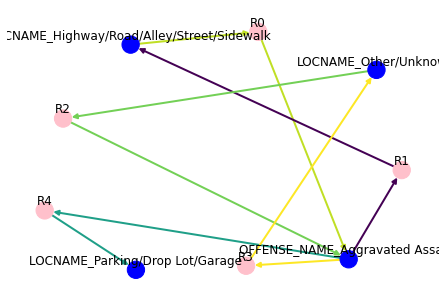

<Figure size 3600x7200 with 0 Axes>

In [395]:
draw_graph (assoc_rules, 5) 

Text(0, 0.5, 'confidence')

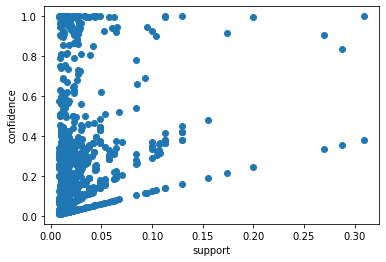

In [396]:
plt.scatter(assoc_rules['support'], assoc_rules['confidence'])
plt.xlabel('support')
plt.ylabel('confidence')

In [397]:
assoc_rules['antec_count'] = assoc_rules['antecedents'].apply(lambda x:len(x) )
idx = np.where((assoc_rules['antec_count']>1) & (assoc_rules['lift']>1))
assoc_rules_filter =assoc_rules.loc[idx]

assoc_rules_filter.sort_values('lift', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antec_count
295,(OFFENSE_NAME_Destruction/Damage/Vandalism of ...,(VICTYPE_Religious Organization),0.026783,0.029338,0.023158,0.864649,29.471749,0.022372,7.171435,2
294,(OFFENSE_NAME_Destruction/Damage/Vandalism of ...,(LOCNAME_Church/Synagogue/Temple/Mosque),0.026715,0.037622,0.023158,0.866860,23.041095,0.022153,7.228306,2
373,(OFFENSE_NAME_Destruction/Damage/Vandalism of ...,(VICTYPE_Government),0.036830,0.028610,0.010238,0.277977,9.716230,0.009184,1.345373,2
821,(OFFENSE_NAME_Destruction/Damage/Vandalism of ...,"(Anti-Jewish, VICTYPE_Other)",0.049072,0.030960,0.012264,0.249930,8.072811,0.010745,1.291934,2
816,"(Anti-Jewish, VICTYPE_Other)",(OFFENSE_NAME_Destruction/Damage/Vandalism of ...,0.030960,0.049072,0.012264,0.396146,8.072811,0.010745,1.574765,2


Confidence measures how often items in the consequent appear in transactions that contain the antecedent. Sorting on confidence:

In [398]:
assoc_rules_filter.sort_values('confidence', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antec_count
269,"(Anti-Gay (Male), OFFENSE_NAME_Aggravated Assa...",(VICTYPE_Individual),0.016240,0.807557,0.016240,1.0,1.238302,0.003125,inf,2
463,"(LOCNAME_Commercial/Office Building, OFFENSE_N...",(VICTYPE_Individual),0.009910,0.807557,0.009910,1.0,1.238302,0.001907,inf,2
898,"(Anti-Jewish, LOCNAME_Other/Unknown, OFFENSE_N...",(VICTYPE_Individual),0.008539,0.807557,0.008539,1.0,1.238302,0.001643,inf,3
245,"(OFFENSE_NAME_Aggravated Assault, LOCNAME_Othe...",(VICTYPE_Individual),0.011039,0.807557,0.011039,1.0,1.238302,0.002124,inf,2
940,"(LOCNAME_Residence/Home, Anti-Jewish, OFFENSE_...",(VICTYPE_Individual),0.011272,0.807557,0.011272,1.0,1.238302,0.002169,inf,3


### Visualizing Apriori based on Lift metric

Below is a heatmap which shows the rules in which the ancedent is of length 2 and lift is greater than 1.

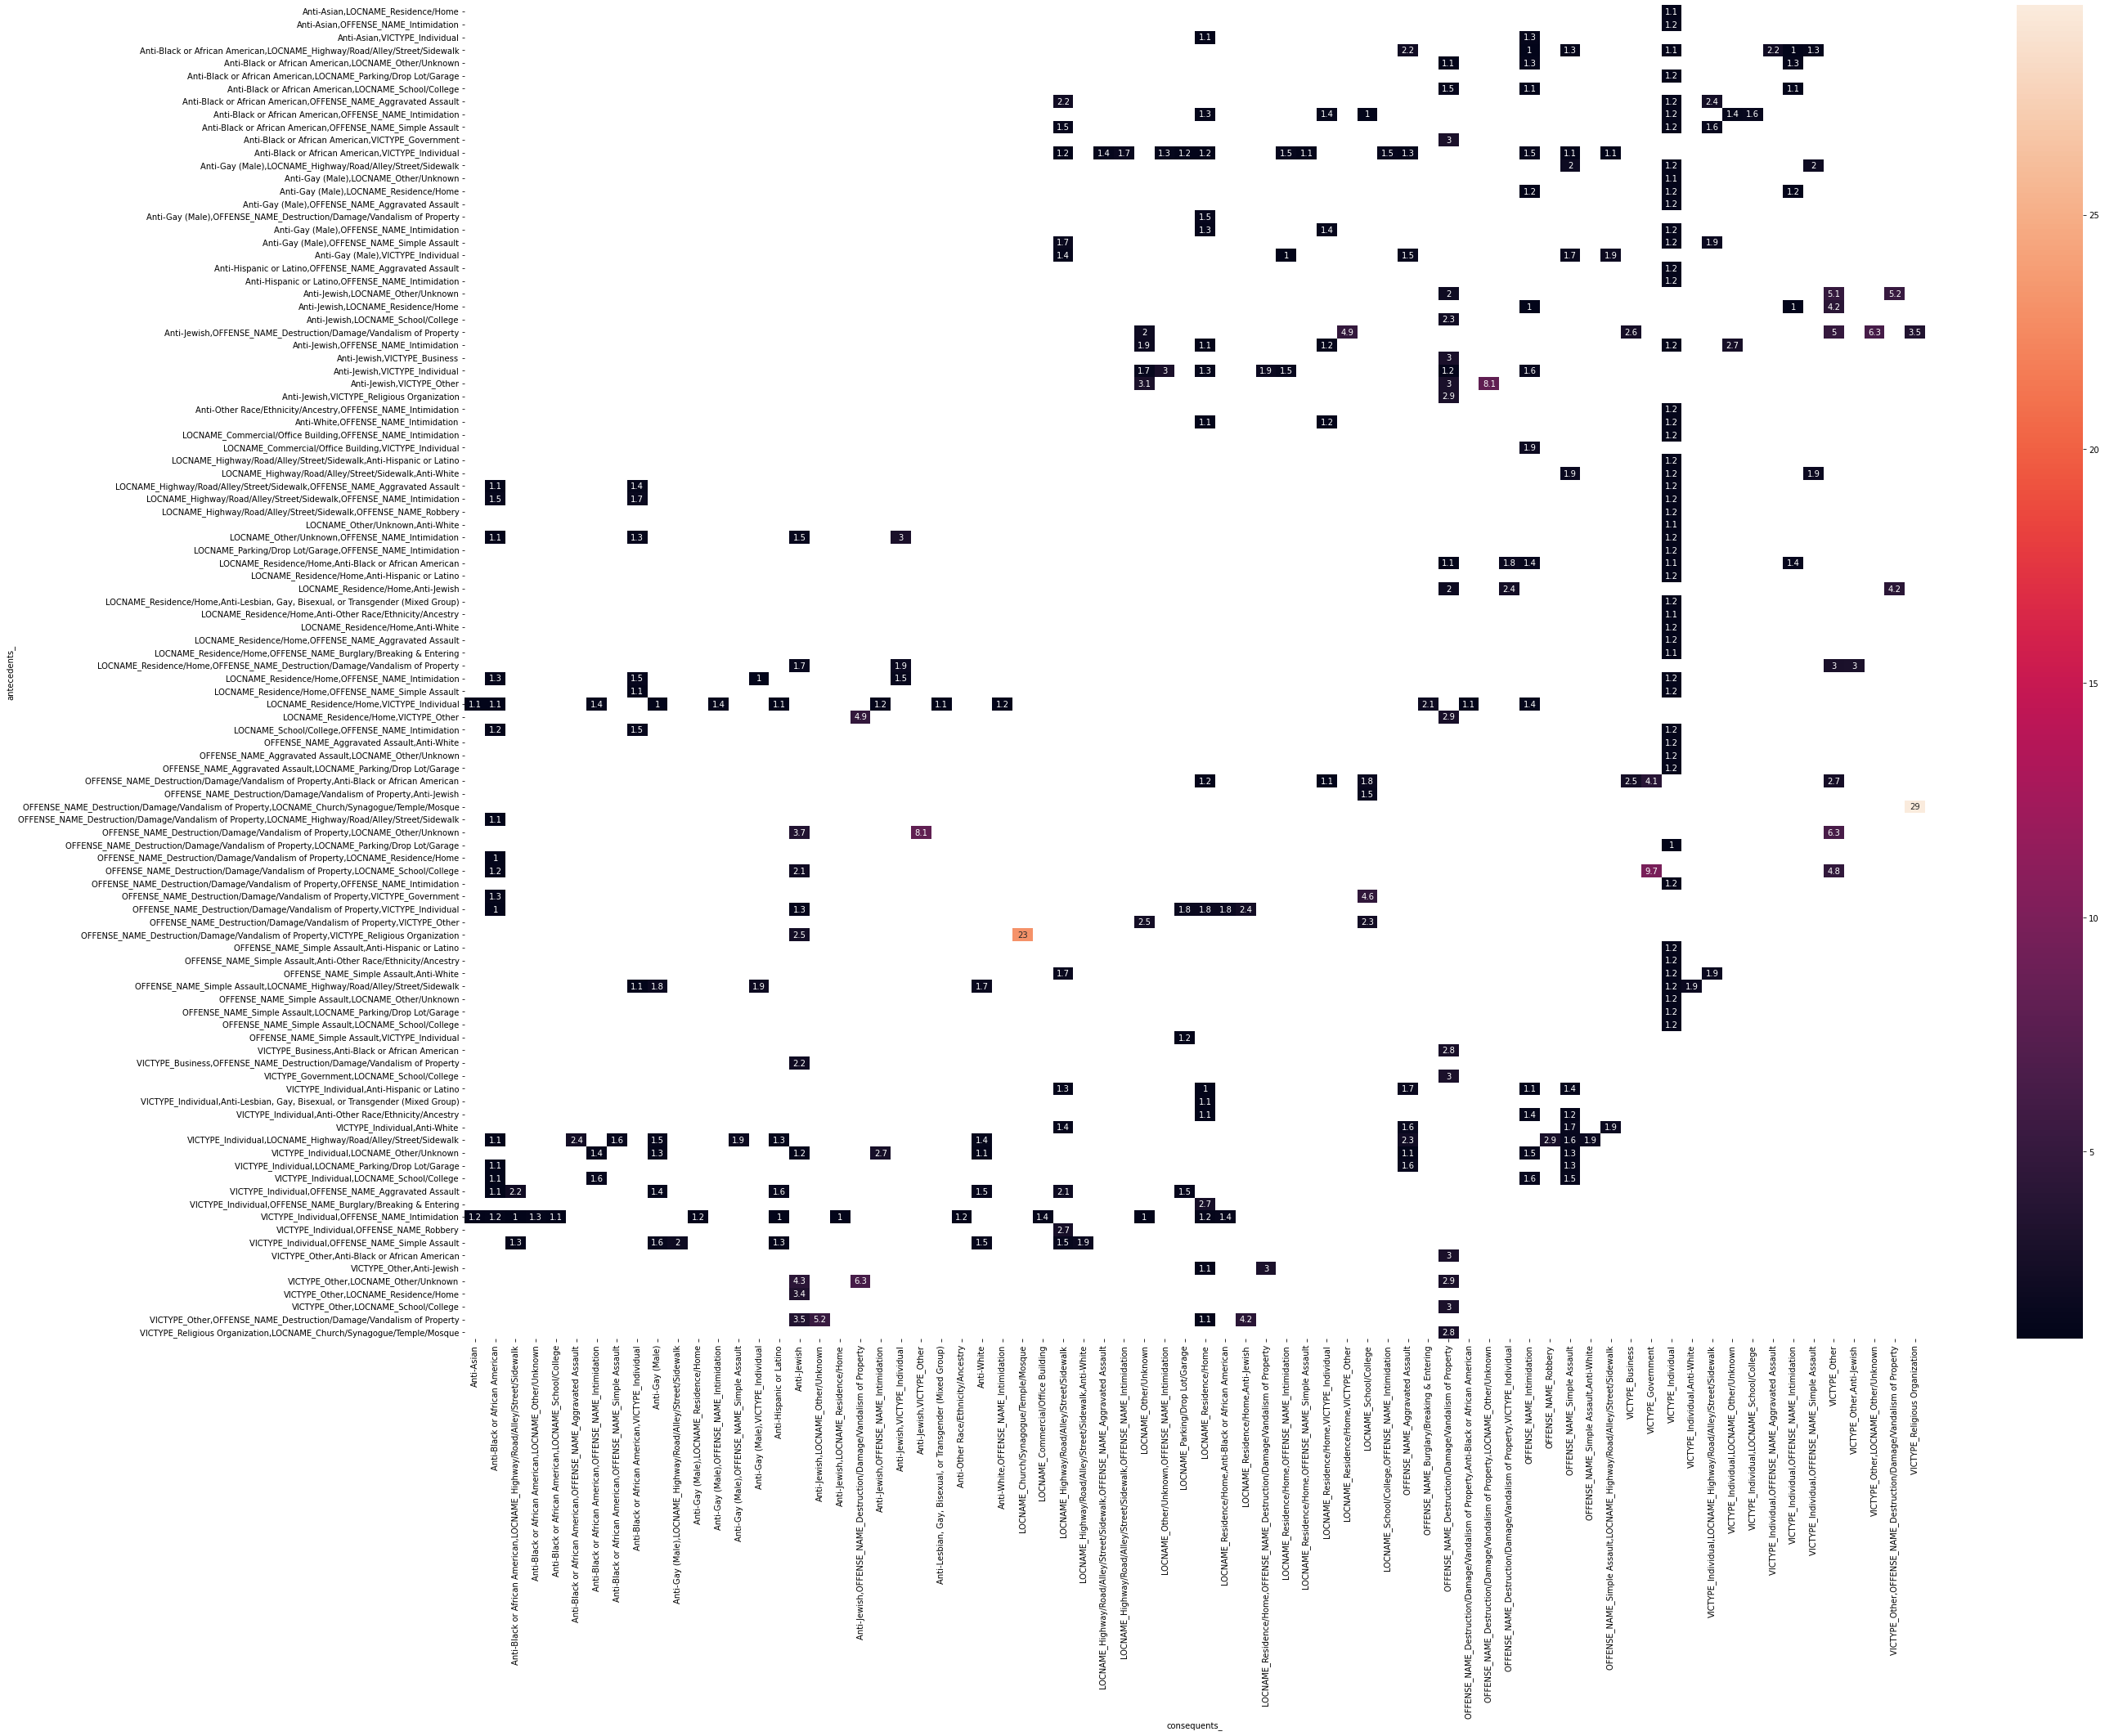

In [406]:
import seaborn as sns
# Replace frozen sets with strings
assoc_rules_filter['antecedents_'] = assoc_rules_filter['antecedents'].apply(lambda a: ','.join(list(a)))
assoc_rules_filter['consequents_'] = assoc_rules_filter['consequents'].apply(lambda a: ','.join(list(a)))
# Transform the DataFrame of rules into a matrix using the lift metric
pivot = assoc_rules_filter[assoc_rules_filter['antec_count']==2].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')
# Generate a heatmap with annotations on and the colorbar off
plt.figure(figsize=(40,30))
sns.heatmap(pivot, annot = True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

Below is a heatmap which shows the rules in which the ancedent is of length 3 and lift is greater than 1.

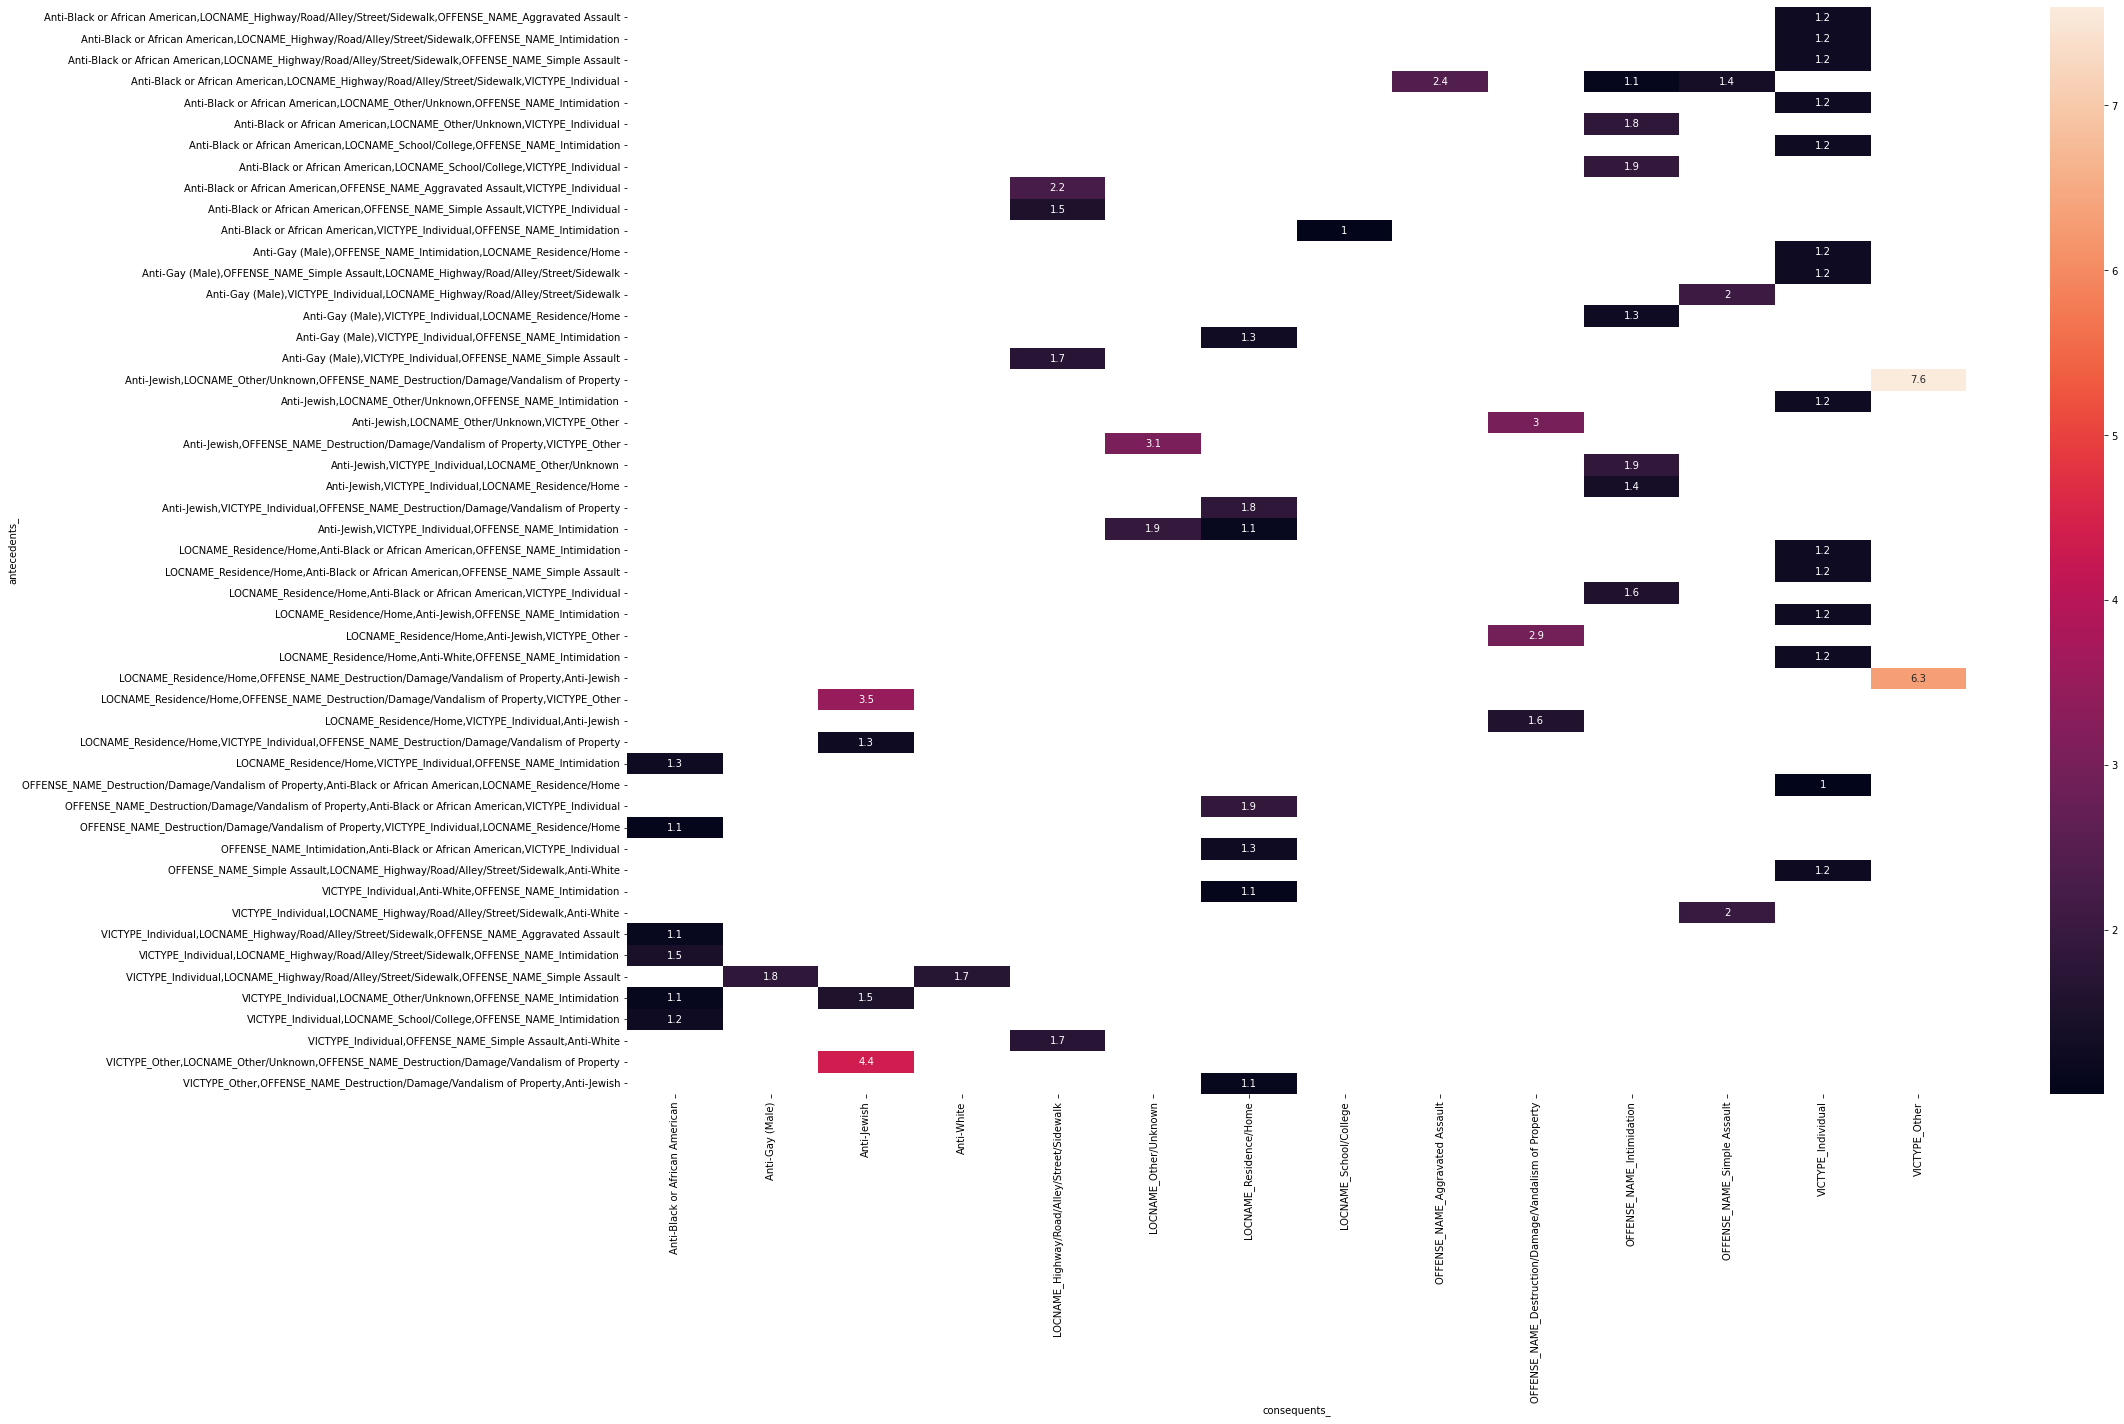

In [407]:
pivot = assoc_rules_filter[assoc_rules_filter['antec_count']==3].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')
# Generate a heatmap with annotations on and the colorbar off
plt.figure(figsize=(30,20))
sns.heatmap(pivot, annot = True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()